In [2]:
#Expected rates of returns for a portfolio in python (Simple way, in future fit an ARME to pot E(r))

In [97]:
#import python's number crunchers and a randomizer

import numpy as np
import pandas as pd
import random
import yfinance as yf

In [22]:
import bs4 as bs    #This code give me a list of all S&P 500 tickers 
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

scraped_tickers = save_sp500_tickers()

In [23]:
# checked the number of items in our list

len(scraped_tickers)

505

In [24]:
# make a portfolio of randomly 5 listed stocks from the big list

random_selection = random.sample(scraped_tickers, 5)
random_selection

['TGT\n', 'CERN\n', 'WHR\n', 'MLM\n', 'GLW\n']

In [14]:
start_date = '2016-09-15'

In [25]:
#Pull Adjusted closing prices with Pandas datareader and check the head of this data


data = pd.DataFrame()

for item in random_selection:
    data[item] = yf.download(item,start=start_date)['Adj Close']

data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,TGT\n,CERN\n,WHR\n,MLM\n,GLW\n
Date,,,,,
2016-09-14,60.842125,61.720238,148.974487,172.512512,20.699249
2016-09-15,61.743172,62.295856,149.672531,172.950165,20.902821
2016-09-16,61.761002,61.551525,147.542130,169.176651,20.930580
2016-09-19,61.457687,61.015606,146.708130,170.168625,21.004604
2016-09-20,61.216812,61.640842,145.447998,169.964401,21.004604


In [26]:
# simple daily returns with .pct_change() method

daily_simple_returns = data.pct_change()
daily_simple_returns.head()

,TGT\n,CERN\n,WHR\n,MLM\n,GLW\n
Date,,,,,
2016-09-14,NaN,NaN,NaN,NaN,NaN
2016-09-15,0.014810,0.009326,0.004686,0.002537,0.009835
2016-09-16,0.000289,-0.011948,-0.014234,-0.021819,0.001328
2016-09-19,-0.004911,-0.008707,-0.005653,0.005864,0.003537
2016-09-20,-0.003919,0.010247,-0.008589,-0.001200,0.000000


In [27]:
# annualise daily returns. 250 trading days in a year

annual_returns = daily_simple_returns.mean() * 250
annual_returns

TGT\n     0.255712
CERN\n    0.077154
WHR\n     0.048647
MLM\n     0.170251
GLW\n     0.144578
dtype: float64

In [28]:
# number of assets in the randomly selected portfolio

num_assets = len(random_selection)
num_assets

5

In [31]:
# sum of weights must equal 1. 
# (a / a+b) + (b / a+b) = 1 
# applying this logic above

weights = np.random.random(num_assets)
weights = weights / sum(weights)
weights

array([0.32192207, 0.01925382, 0.2250267 , 0.20190085, 0.23189656])

In [32]:
#Calculate portfolio adjusted returns
port_returns_expected = np.sum(weights * annual_returns)
port_returns_expected

0.16265271632886433

In [100]:

volat = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
volat

0.16305628743622694

In [33]:
# convert the float into a percentage cos why not ;)

print(str(round(port_returns_expected * 100, 2)) + '%')

16.27%


##### 2.This part implementes efficient frontier of the portfolio: 

In [38]:
# import needed modules

import matplotlib.pyplot as plt




In [102]:
cov_daily = daily_simple_returns.cov()
cov_annual = cov_daily * 250
volat = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
print(cov_annual, volat)

           TGT\n    CERN\n     WHR\n     MLM\n     GLW\n
TGT\n   0.087981  0.010068  0.016763  0.013330  0.015365
CERN\n  0.010068  0.053279  0.016088  0.009021  0.018810
WHR\n   0.016763  0.016088  0.080983  0.020892  0.024554
MLM\n   0.013330  0.009021  0.020892  0.068735  0.014803
GLW\n   0.015365  0.018810  0.024554  0.014803  0.059747 0.16305628743622694


In [70]:
# empty lists to store returns, volatility and weights of imaginary portfolios
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_portfolios = 50000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)    #understand good the meaning of /=
    
    returns = np.dot(weights, annual_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))  #volatility of portfolio
    
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(data):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' weight' for stock in data]

# reorder dataframe columns
df = df[column_order]

df.head()

,Returns,Volatility,TGT\n weight,CERN\n weight,WHR\n weight,MLM\n weight,GLW\n weight
0,0.137793,0.166622,0.267566,0.291449,0.214312,0.143699,0.082974
1,0.089173,0.182278,0.013444,0.370838,0.340031,0.028182,0.247505
2,0.144407,0.201126,0.384056,0.035945,0.440497,0.071194,0.068307
3,0.118580,0.176279,0.008109,0.156448,0.228985,0.218717,0.387741
4,0.179031,0.186067,0.316167,0.118996,0.053663,0.486396,0.024778


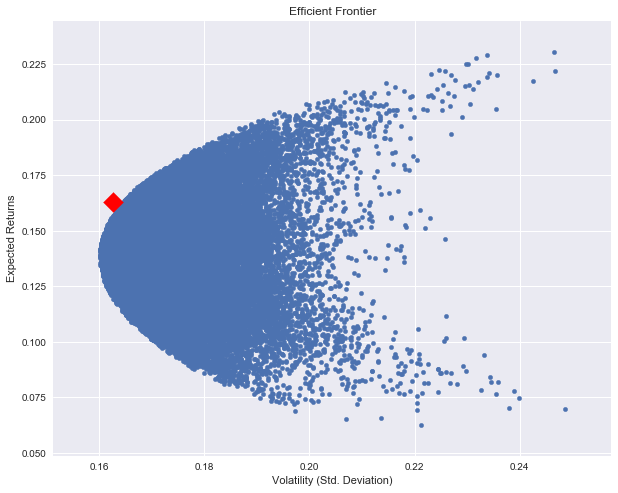

In [106]:
# plot the efficient frontier with a scatter plot
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.scatter(x=port_returns_expected, y=volat, c='red', marker='D', s=200)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

If now I want to compute Sharpe Ratios: 

In [72]:
sharpe_ratio = []

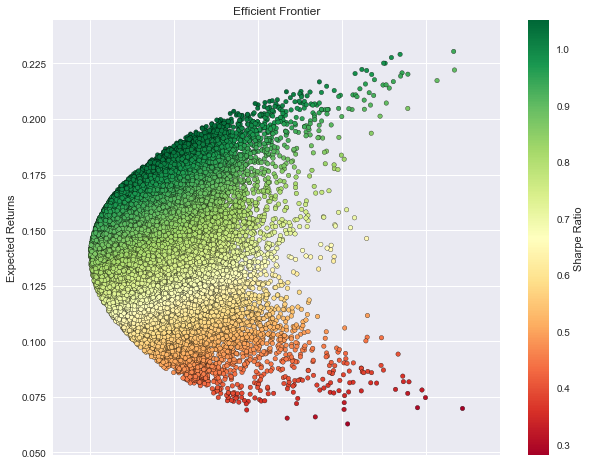

In [75]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []
risk_free_rate = 0

# set the number of combinations for imaginary portfolios
num_portfolios = 50000

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, annual_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = (returns - risk_free_rate) / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(data):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in data]

# reorder dataframe columns
df = df[column_order]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

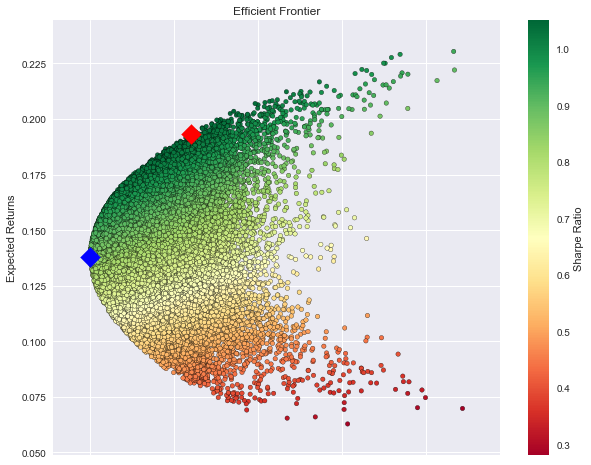

In [76]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [77]:
print(min_variance_port.T)
print(sharpe_portfolio.T)

                  25538
Returns        0.138074
Volatility     0.160125
Sharpe Ratio   0.862289
TGT\n Weight   0.175503
CERN\n Weight  0.304377
WHR\n Weight   0.114355
MLM\n Weight   0.213617
GLW\n Weight   0.192148
                   6004
Returns        0.193213
Volatility     0.183924
Sharpe Ratio   1.050505
TGT\n Weight   0.416377
CERN\n Weight  0.062437
WHR\n Weight   0.003153
MLM\n Weight   0.267750
GLW\n Weight   0.250284


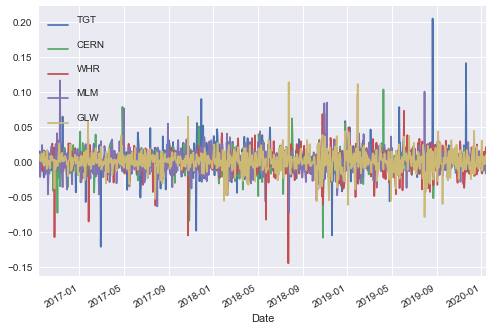

In [94]:
plt.style.use('seaborn')
daily_simple_returns.plot()
plt.legend()
plt.show()

In [ ]:
np.random.randint()